# Google Api Test

In [1]:
import lib.google_nlp as gnlp
from lib.tokenize_to_sentences import tokenize_to_sentences, trim_new_line
from lib.aylien_nlp import summarize
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [2]:
ANALYSIS_TITLE = ''

ANALYSIS_TEXT = '''I really wanted to love 'Bladerunner' but ultimately I couldn't get
myself to appreciate it fully. However, you may like it if you're into
science fiction, especially if you're interested in the philosophical
exploration of what it means to be human or machine. Some of the gizmos
like the flying cars and the Vouight-Kampff machine (which seemed very
steampunk), were quite cool.

I did find the plot pretty slow and but the dialogue and action sequences
were good. Unlike most science fiction films, this one was mostly quiet, and
not all that much happened, except during the last 15 minutes. I didn't
understand why a unicorn was in the movie. The visual effects were fantastic,
however, and the musical score and overall mood was quite interesting.
A futurist Los Angeles that was both highly polished and also falling apart
reminded me of 'Outland.' Certainly, the style of the film made up for
many of its pedantic plot holes.

If you want your sci-fi to be lasers and spaceships, 'Bladerunner' may
disappoint you. But if you want it to make you think, this movie may
be worth the money.'''

sentences = tokenize_to_sentences(ANALYSIS_TEXT)
print('\n'.join(sentences))

I really wanted to love 'Bladerunner' but ultimately I couldn't get myself to appreciate it fully.
However, you may like it if you're into science fiction, especially if you're interested in the philosophical exploration of what it means to be human or machine.
Some of the gizmos like the flying cars and the Vouight-Kampff machine (which seemed very steampunk), were quite cool.
I did find the plot pretty slow and but the dialogue and action sequences were good.
Unlike most science fiction films, this one was mostly quiet, and not all that much happened, except during the last 15 minutes.
I didn't understand why a unicorn was in the movie.
The visual effects were fantastic, however, and the musical score and overall mood was quite interesting.
A futurist Los Angeles that was both highly polished and also falling apart reminded me of 'Outland.'
Certainly, the style of the film made up for many of its pedantic plot holes.
If you want your sci-fi to be lasers and spaceships, 'Bladerunner' 

In [3]:
# helper functions

def print_sentiment(text, polarity, magnitude):
    print('Text: %s' % text)
    print('Sentiment: polarity of %s with magnitude of %s' % (polarity, magnitude))
    
def load_dump(path):
    return pickle.load(open(path, 'rb'))

#### Analyze and print sentiment for the document:

In [4]:
# Run a sentiment analysis request on text in ANALYSIS_TEXT variable
polarity, magnitude = gnlp.google_sentiment_analysis(ANALYSIS_TEXT)
print('Document Sentiment: polarity of %s with magnitude of %s' % (polarity, magnitude))
print()

Document Sentiment: polarity of -0.1 with magnitude of 6.7



#### Analyze sentiment for each sentence and store a dump:

In [5]:
# analyze using Google API
sentiments = [gnlp.google_sentiment_analysis(sentence) for sentence in sentences]
results = list(zip(sentences, sentiments))

# store to tmp file
pickle.dump(results, open('tmp/google-sentiment-results', 'wb'))

# print success
print('Stored %d results' % len(list(results)))

Stored 11 results


#### Analyze syntax for each sentence and store a dump:

In [6]:
# analyse using Google API
syntax = [gnlp.google_syntax_analysis(sentence) for sentence in sentences]
syntax_results = list(zip(sentences, syntax))

# store to tmp file
pickle.dump(syntax_results, open('tmp/google-syntax-results', 'wb'))

# print success
print('Stored %d results' % len(syntax_results))


Stored 11 results


#### Print sentiment for each sentence:

In [7]:
results = load_dump('tmp/google-sentiment-results')
print('Have found %d results\n\n' % len(list(results)))

for r in results:
    text, (polarity, magnitude) = r
    print_sentiment(text, polarity, magnitude)
    print('\n\n')

Have found 11 results


Text: I really wanted to love 'Bladerunner' but ultimately I couldn't get myself to appreciate it fully.
Sentiment: polarity of -1 with magnitude of 0.8



Text: However, you may like it if you're into science fiction, especially if you're interested in the philosophical exploration of what it means to be human or machine.
Sentiment: polarity of -1 with magnitude of 0.4



Text: Some of the gizmos like the flying cars and the Vouight-Kampff machine (which seemed very steampunk), were quite cool.
Sentiment: polarity of 1 with magnitude of 0.8



Text: I did find the plot pretty slow and but the dialogue and action sequences were good.
Sentiment: polarity of 1 with magnitude of 0.1



Text: Unlike most science fiction films, this one was mostly quiet, and not all that much happened, except during the last 15 minutes.
Sentiment: polarity of -1 with magnitude of 0.8



Text: I didn't understand why a unicorn was in the movie.
Sentiment: polarity of -1 with magnitude

#### Build histogram for sentiment distribution:

In [8]:
results = load_dump('tmp/google-sentiment-results')
distribution = [ r[1][0] * r[1][1] for r in results ]

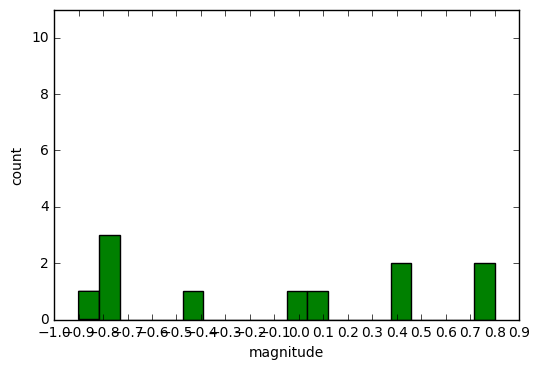

In [9]:
# histogram showing magnitudes
plt.hist(distribution, 20, facecolor='g')
plt.xlabel('magnitude')
plt.xticks(np.arange(-1, 1, 0.1))
plt.ylabel('count')
plt.ylim(0, len(results))
plt.show()

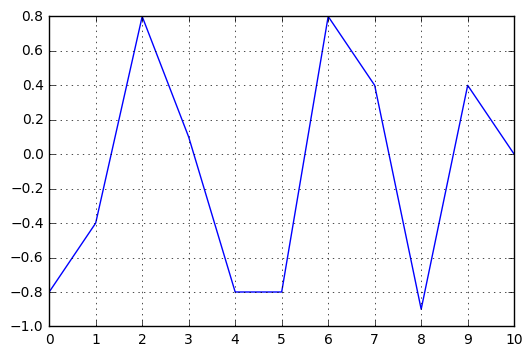

In [10]:
# histogram showing polarity, magnitude in chronological order
plt.plot(distribution)
plt.xticks(np.arange(0, len(distribution), 1.0))
plt.grid()
plt.show()

# Summary Building

First we preprocess our text data by building rankings of sentences by sentiment and finding an adequate summary sentence. Then we apply rules for how we put the article together. See these documents:

- https://docs.google.com/spreadsheets/d/1Q3RqbrvmC2LTuds31R6HSkHc2CpuxZgPJbR5vVsMHlM/edit#gid=0
- https://docs.google.com/document/d/1xWHVi3AaCSE2GduW194sUCYU6peStF4vTctzCZcNYkU/edit

#### Ranking of Sentences

We build a ranking of each sentence by chronological order vs. mag*pol score

In [11]:
sentence_score_tuples = list(zip(range(len(distribution)), distribution))
positives = [t for t in sentence_score_tuples if t[1] >= 0.5]
negatives = [t for t in sentence_score_tuples if t[1] <= -0.5]

# get key to sort by absolute score == magnitude
def getKey(item):
    return item[1]

positives_sorted = sorted(positives, key=getKey)
negatives_sorted = sorted(negatives, key=getKey)

#### Extracting one summary sentence via aylien api

In [12]:
# configure summarization api
options = {
    'mode': 'short',
    'title': ANALYSIS_TITLE,
    'text': trim_new_line(ANALYSIS_TEXT),
    'sentences_number': 1
}

# make api call and cache result
summary_results = summarize(options)
pickle.dump(summary_results, open('tmp/aylien-summary', 'wb'))

In [13]:
summary_results = load_dump('tmp/aylien-summary')
summary_sentences = summary_results['sentences']

#### Filter Summary sentences from ranked positives and negatives

In [14]:
positives_filtered = [p for p in positives_sorted if results[p[0]][0] not in summary_sentences]
negatives_filtered = [p for p in negatives_sorted if results[p[0]][0] not in summary_sentences]

# print filtered & unfiltered counts, so we see where a sentences was deleted
print(negatives_filtered, len(negatives_filtered), len(negatives_sorted))
print(positives_filtered, len(positives_filtered), len(positives_sorted))

[(8, -0.9), (4, -0.8), (5, -0.8)] 3 4
[(2, 0.8), (6, 0.8)] 2 2


#### Logic for Syntax Splitting

In [15]:
SPLIT_LABELS = [
    'CC',
    'P',
    'MARK'
]

NO_WHITESPACE_LABELS = [
    'P',
    'NEG'
]

def join_tokens(tokens, _from, _to): 
    sentence = ''
#     print()
    for i in range(_from, _to):
        t = tokens[i]
#         print(t['label'], t['text'])
        if t['label'] in NO_WHITESPACE_LABELS:
            sentence = sentence[:-1]
        sentence = sentence + t['text'] + ' '
    return sentence
    
def find_splits(sentence, tokens, max_characters):
    split_index = find_split_index(sentence, tokens, max_characters)
    if split_index == len(tokens):
        return [sentence]
    
    return [join_tokens(tokens, 0, split_index), join_tokens(tokens, split_index, len(tokens))]
    
def find_split_index(sentence, tokens, max_characters=125):
    character_count = len(sentence)
    split_index = len(tokens)
    
    for t in reversed(tokens):
        character_count -= len(t['text'])
     
        if t['label'] in SPLIT_LABELS:
            if character_count <= max_characters:
                return split_index
            
        split_index = split_index - 1
            
    return len(tokens)

# def find_split_position(sentence, tokens, max_characters=125):
#     character_count = len(sentence)
#     force_split_position = max_characters
#     for t in reversed(tokens):
#         character_count -= len(t['text'])
#         if character_count + len(t['text']) > max_characters:
#             force_split_position = character_count
        
#         if t['label'] in SPLIT_LABELS:
#             print(t['label'], character_count)
#             if character_count <= max_characters:
#                 print(t['label'])
#                 return character_count
            
#     return force_split_position

def splitSentence(syntaxes, sentence, index, max_characters=125):
    '''Split a sentence into two parts, when it is longer then max_characters.
    We try to split at meaningful points, e.g. connector words like and'''
    if len(sentence) > max_characters:
        tokens = [{
            'label': t['dependencyEdge']['label'],
            'text': t['text']['content']
            } for t in syntaxes[index][1]['tokens']]
#         split_position = find_position(sentence, tokens, max_characters)
#         return [sentence[:split_position], sentence[split_position:]]
        return find_splits(sentence, tokens, max_characters)
    return [sentence]

In [23]:
syntax_results = load_dump('tmp/google-syntax-results')

def getSentences(score_tuples, sentences):
    '''Returns the original sentences for a score_tuple list'''
    return [(t[0], sentences[t[0]][0]) for t in score_tuples]

def gatherSentences(sentences_list, 
                    max_count=2,
                    max_characters=250,
                    max_split_characters=125,
                    skip_indices=[]):
    '''Builds a list of sentences greedily, so they are not longer 
    than max_characters.'''
    sentences = []
    indices = []
    for (index, s) in sentences_list:
        if index in skip_indices:
            continue
        if len(sentences) >= max_count:
            break
        if len(s) < max_characters:
            splits = splitSentence(syntax_results, s, index, max_split_characters)
            if len(sentences) + len(splits) <= max_count:
                indices.append(index)
                sentences += splits
            
    return (sentences, indices)

(pos, _) = gatherSentences(getSentences(positives_filtered, results))
(neg, neg_indices) = gatherSentences(getSentences(negatives_filtered, results))

summary_syntaxes = list(zip(summary_sentences, [gnlp.google_syntax_analysis(sentence) for sentence in summary_sentences]))
summary = splitSentence(summary_syntaxes, summary_sentences[0], 0, 125)

max_count = 6 - len(pos) - len(neg) - len(summary)
remaining_neg = []
if max_count > 0:
    (remaining_neg, _) = gatherSentences(getSentences(negatives_filtered, results), max_count=max_count, skip_indices=neg_indices)
    

print(pos)
[print(len(s)) for s in pos]
print()
print(neg)
[print(len(s)) for s in neg]
print()
print(summary)
[print(len(s)) for s in summary]

['Some of the gizmos like the flying cars and the Vouight-Kampff machine (which seemed very steampunk), were quite cool.', 'The visual effects were fantastic, however, and the musical score and overall mood was quite interesting.']
118
105

['Certainly, the style of the film made up for many of its pedantic plot holes.', "I didn't understand why a unicorn was in the movie."]
77
51

["I really wanted to love 'Bladerunner' but ultimately I couldn't get myself to appreciate it fully."]
98


[None]

# Final Summary

In [24]:
# build summary from analized sentences...
final_summary = neg + summary + remaining_neg + pos
print('\n'.join(final_summary))

Certainly, the style of the film made up for many of its pedantic plot holes.
I didn't understand why a unicorn was in the movie.
I really wanted to love 'Bladerunner' but ultimately I couldn't get myself to appreciate it fully.
Some of the gizmos like the flying cars and the Vouight-Kampff machine (which seemed very steampunk), were quite cool.
The visual effects were fantastic, however, and the musical score and overall mood was quite interesting.
